In [1]:
import uproot
import matplotlib.pyplot as plt
import numpy as np
import compress_pickle as pickle  
import mplhep as hep
import math
from scipy.optimize import curve_fit
import compress_pickle
import pickle
import gzip
hep.style.use("CMS")

## Saved Models for different configuration
### If you have multiple models, this is where you can list them

In [2]:
# Format is (particle, input feature dimensions, output feature dimensions,
# energy weight, theta weight, phi weight)
conditions = {
    ('lambda', '4D', '3D', None, None, None):{
    'result_dir': '/home/sebastian/ai_studies_24/regressiononly/src/data/results_lambda3D/',
    'preprocessed_dir': '/home/sebastian/ai_studies_24/regressiononly/src/data/preprocessed_data_lambda3D/',
    'discrete_data':'/media/miguel/Elements/zdc_data/zdc_neutron_log10discrete_10GeV-300GeV_0.0deg-0.3deg_staggered_h4_01_26_2024/',
    'continuous_data': '/media/miguel/Elements/zdc_data/zdc_neutron_log10continuous_10GeV-300GeV_0.0deg-0.3deg_staggered_h4_01_26_2024/'
    },
    ('lambda', '4D', '1D', None, None, None):{
    'result_dir': '/home/sebastian/ai_studies_24/regressiononly/src/data/results_lambda1D/',
    'preprocessed_dir': '/home/sebastian/ai_studies_24/regressiononly/src/data/preprocessed_data_lambda1D/',
    'discrete_data':'/media/miguel/Elements/zdc_data/zdc_neutron_log10discrete_10GeV-300GeV_0.0deg-0.3deg_staggered_h4_01_26_2024/',
    'continuous_data': '/media/miguel/Elements/zdc_data/zdc_neutron_log10continuous_10GeV-300GeV_0.0deg-0.3deg_staggered_h4_01_26_2024/'
    },
    # ZDC paper results
    ('neutron', '4D', '2D', '.5', '.5', None):{
    'result_dir': '/home/ryan/zdc_studies/results/results_for_paper/results_4D_output2D_zdc_h4_neutron_graphnet_correctdynamicrange_energy0.5_theta0.5/ECCE_20240129-1333_graphnet_4D/',
    'preprocessed_dir': '/home/ryan/zdc_studies/preprocessed_data/preprocessed_input4D_output2D_zdc_h4_neutron_graphnet_energy0.5_theta0.5_correctdynamicrange/',
    'discrete_data':'/media/miguel/Elements/zdc_data/zdc_neutron_log10discrete_10GeV-300GeV_0.0deg-0.3deg_staggered_h4_01_26_2024/',
    'continuous_data': '/media/miguel/Elements/zdc_data/zdc_neutron_log10continuous_10GeV-300GeV_0.0deg-0.3deg_staggered_h4_01_26_2024/'
    },
    ('neutron', '4D', '3D', None, None, None):{
    'result_dir': '/home/ryan/lambda0_decay_ML/src/data/results_neutron_3D/',
    'preprocessed_dir': '/home/ryan/lambda0_decay_ML/src/data/preprocessed_data_neutron_3D/',
    'discrete_data':'/media/miguel/Elements/zdc_data/zdc_neutron_log10discrete_10GeV-300GeV_0.0deg-0.3deg_staggered_h4_01_26_2024/',
    'continuous_data': '/media/miguel/Elements/zdc_data/zdc_neutron_log10continuous_10GeV-300GeV_0.0deg-0.3deg_staggered_h4_01_26_2024/'
    }
}
default_entry = {
    'result_dir': 'No_File',
    'preprocessed_dir': 'No_Title',
}

### Pick the model you want based on options

In [3]:
particle ='neutron'  # pi+,  pi0, neutron, gamma
input_features='4D'  ## input features [4D, 2D, 1D]
output_dim='3D'    ## '1D', '2D', '3D'
energy_weight=None ## None if no energy weight, 'energy_weight' otherwise
theta_weight=None ## None if no theta weight, 'theta_weight' otherwise
phi_weight =None

entry = conditions.get((particle,
                        input_features,
                        output_dim,
                        energy_weight,
                        theta_weight,
                        phi_weight),
                       default_entry)
path_to_result = entry['result_dir']
path_to_stat = entry['preprocessed_dir']

if entry['result_dir'] == 'No_File':
    print('File not found')    

print(path_to_result)  

/home/ryan/lambda0_decay_ML/src/data/results_neutron_3D/


### Get model's predictions and target variables

In [4]:
# Will likely need to change name of npz file for your use case
npz_unpacked = np.load(path_to_result+"/predictions_appended_test.npz") 

predictions_unnormalized = npz_unpacked['outputs_scaled']
targets_unnormalized = npz_unpacked['targets_scaled']

if output_dim == '3D':
    targets_energy = targets_unnormalized[:,0]
    targets_theta = targets_unnormalized[:,1]
    targets_phi = targets_unnormalized[:,2]

    predictions_energy = predictions_unnormalized[:,0]
    predictions_theta = predictions_unnormalized[:,1]
    predictions_phi = predictions_unnormalized[:,2]
elif output_dim == '2D':
    targets_energy = targets_unnormalized[:,0]
    targets_theta = targets_unnormalized[:,1]

    predictions_energy = predictions_unnormalized[:,0]
    predictions_theta = predictions_unnormalized[:,1]
elif output_dim == '1D':
    targets_energy = targets_unnormalized
    predictions_energy = predictions_unnormalized
else:
    print("Output dimensions isn't 1D, 2D, or 3D")
    
# Obtaining the file names and event numbers for each entry
meta_info_initial = npz_unpacked['meta']
meta_info =[]
# The saved meta is in the form of [file_name, event_num, file_name, event_num, ...]
# Put it in the form [(file_name, event_num), (file_name, event_num), ...]
# This aligns its length with the lengths of targets and predictions
for i, element in enumerate(meta_info_initial):
    if i%2 == 0:
        file_name = meta_info_initial[i]
        event_num = int(meta_info_initial[i+1])
        # putting the file names and event numbers into a tuple
        meta_tuple = (file_name, event_num) 
        meta_info.append(meta_tuple)
    else:
        continue
# Data type for each entry is (string, int), i.e. (object, int)
meta_info = np.asarray(meta_info, dtype='object,int') 

### Inspect loss curve

[0.13641463 0.10310087 0.09496345 0.09053839 0.08820194 0.08687877
 0.08616692 0.0857855  0.08560012 0.08549444 0.08543988 0.08542556
 0.08541384 0.08540136 0.08538982]


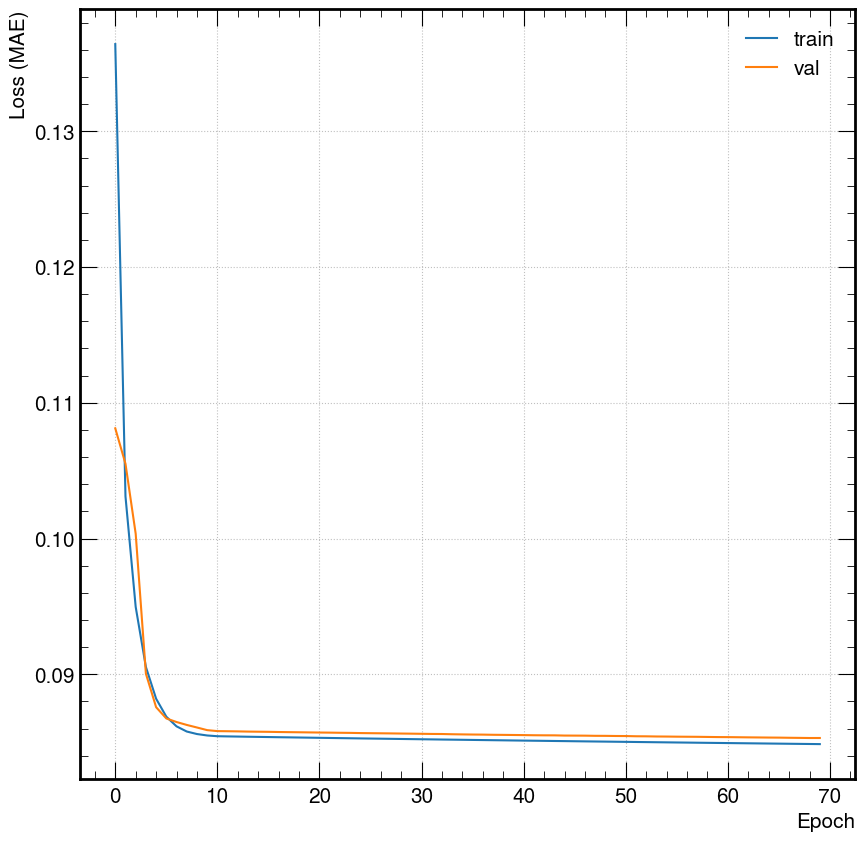

In [5]:
npz_unpacked_loss = np.load(path_to_result + "/losses.npz")

train_loss = npz_unpacked_loss['training']
val_loss = npz_unpacked_loss['validation']

val_mean_loss=np.mean(val_loss, axis=1)
train_mean_loss=np.mean(train_loss, axis=1)

plt.plot(train_mean_loss,label='train')

plt.plot(val_mean_loss, label='val')
plt.xlabel("Epoch", fontsize=15)
plt.ylabel("Loss (MAE)", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.grid()
print(train_mean_loss[:15])

### Creating bins based on energies of the test data

In [6]:
# Returns a sorted array of unique target energies
energy_bins = np.unique(np.round(targets_energy).astype(int))
print(energy_bins)

[ 10  11  12  13  14  16  17  19  21  24  26  29  32  35  39  43  47  52
  57  63  70  77  85  93 103 114 125 138 152 168 185 204 225 248 274 302]


## Will now calculate resolutions based on model predictions

### Define functions for fitting

In [7]:
# Gaussian functional form
def gaussian(x, amp, mean, sigma_squared):
    return amp * np.exp( -0.5*((x - mean)**2/sigma_squared))
# Function to fit with the Gaussian
# Returns two tuples:
# (mean of gaussian fit, error of mean of gaussian fit)
# (std. dev. of gaussian fit, error of std. dev. of gaussian fit)
def gaussian_fit_on_distribution(nsigma_fit_range,
                                 sigma_of_data,
                                 mean_of_data,
                                 bin_centers,
                                 bin_counts,
                                 ax):
    # Mask to get the bins within +- nsigma_fit_range*sigma_of_data of mean_of_data
    # e.g. fitting within +- 3 sigma of mean
    fit_range_mask = (bin_centers > (mean_of_data - nsigma_fit_range*sigma_of_data))\
    & (bin_centers < (mean_of_data + nsigma_fit_range*sigma_of_data))
    
    try:
        # Fitting the data with a Gaussian
        param_bounds=([0,-np.inf,0], [np.inf,np.inf,np.inf])
        popt, pcov = curve_fit(gaussian,
                              bin_centers[fit_range_mask],
                              bin_counts[fit_range_mask],
                              p0 = [np.max(bin_counts), mean_of_data, sigma_of_data*sigma_of_data],
                              bounds = param_bounds)
        # Errors of each fit parameter
        errors = np.sqrt(np.diag(pcov))
    except Exception as e:
        # Log the exception for debugging purposes
        print(f"Exception occurred during curve fitting: {e}")
        return None  # Explicitly return None in case of an exception
    else:
        # Drawing the fit
        ax.plot(bin_centers[fit_range_mask],
                gaussian(bin_centers[fit_range_mask], *popt),
                color='red',
                linewidth=2.5)

        fit_mean = popt[1]
        fit_std = np.sqrt(popt[2])
        fit_mean_error = errors[1]
        fit_std_error = 0.5*errors[2]/popt[2]*fit_std

        return (fit_mean, fit_mean_error), (fit_std, fit_std_error)
# Propogates the errors of dividing two quantities with errors
# Returns tuple with divided number and new error
def DivideWithErrors(numerator, numerator_error, denominator, denominator_error):
    divided = numerator/denominator
    error = divided * np.sqrt((numerator_error/numerator)**2
                              + (denominator_error/denominator)**2)
    return (divided, error)
# Propogates the errors of adding two quantities with errors
# Returns tuple with added number and new error
def AddWithErrors(num1, num1_error, num2, num2_error):
    summed = num1 + num2
    error = np.sqrt(num1_error * num1_error + num2_error * num2_error)
    return (summed, error)

def AverageWithErrors(value_list, error_list):
    num_entries = len(value_list)
    if num_entries != len(error_list):
        print("Averaging: List are not equal length!")
    average = np.sum(np.asarray(value_list))/(num_entries)
    error = np.sqrt(np.sum(np.square(np.asarray(error_list)))/(num_entries*num_entries))
    return (average, error)

In [8]:
# Function that plots the energy distributions and returns an array of the energy resolution and scales
def get_resolutions(data_to_fit,
                    genE,
                    binning,
                    nbins,
                    data_name = "energy", # Either "energy", "theta", or "phi"
                    divide_by_genE = False,
                    title=""):   
    N_Bins=len(binning)
    
    n_sigma_fit= 3 # fit within +- 3 sigma   
    plot_range = 3                                                                                                                                                                                                          
    row=math.ceil(np.sqrt(N_Bins))
    if (row**2-N_Bins)>row:
        col=row-1
    else:
        col=row

    resolution_list = []
    resolution_error_list = []
    energy_scale_list = []
    energy_scale_error_list = []
    events_below_3sigma_list = []

    y_ticks_size=14
    x_ticks_size=14
    major_x_locator=0.25
    unit = "GeV"
    
    fig,axs = plt.subplots(row,col, figsize=(18, 15),sharex=False)
    plt.subplots_adjust(wspace=0, hspace=0.3)

    # Rounding generated energies to nearest integers
    genE = np.rint(genE)

    # Putting each event in its associated energy bin
    # Will get a np array with each entry being the bin number of the event
    indecies = np.digitize(genE, binning)-1 

    # Making sure there are no negative indecies
    # These would be entries that are smaller than the lowest bin edge
    indecies = np.where(indecies < 0, 0, indecies) 
    if any(indecies<0): print(indecies)

    # Takes the number of entries from the bin with the most entries
    max_count = np.max(np.bincount(indecies)) 

    # Will store the event quantity in these arrays
    # 2D array: N_bins number of arrays, each initalized to allow for max number of bin entries
    binned_data = np.empty((N_Bins, max_count))
    binned_data.fill(np.nan)
    
    # Arrays used to count the number of events in each energy bin
    event_counter = np.zeros(N_Bins, int)
    # In case there are multiple energies within a bin,
    # this will give the mean energy of the entries in that bin
    avg_truth = np.zeros(N_Bins, float)

    # Storing the energies in binned_quantity arrays
    for i in range(len(genE)):
        bin = indecies[i]
        # Skipping events that are greater than the max bin edge
        if (bin>=N_Bins): continue
        if data_name == "energy" and divide_by_genE:
            binned_data[bin][event_counter[bin]] = data_to_fit[i]/genE[i]
        else:
            binned_data[bin][event_counter[bin]] = data_to_fit[i] 
        avg_truth[bin] += genE[i]                                                      
        event_counter[bin]+=1
    
    avg_truth = avg_truth/event_counter
    
    # Removing any nan entries and taking mean/std. deviation
    data_stdev = np.nanstd(binned_data, axis=1)
    data_mean = np.nanmean(binned_data, axis=1)


    for i_bin in range(N_Bins):
        
        # Using the means and std. dev of bin data
        # as the initial values for the Gaussian fit
        bin_mean = data_mean[i_bin]
        bin_stddev = data_stdev[i_bin]
        
        # Min and max range for histogram                                                                                  
        min_range = bin_mean - plot_range * bin_stddev
        max_range = bin_mean + plot_range * bin_stddev
        
        irow=int(i_bin/col)
        icol=int(i_bin%col)

        if irow < row:
            
            ax = axs[irow,icol]
            i_data = binned_data[i_bin][~np.isnan(binned_data[i_bin])]
            bin_counts, bin_edges, _ = ax.hist(i_data,
                                     bins = nbins,
                                     alpha=0.5,
                                     range=(min_range, max_range),
                                     color='b',
                                     linewidth=8)
            
            bin_counts = bin_counts[~np.isnan(bin_counts)]
            bin_edges = bin_edges[~np.isnan(bin_edges)]
            
            bin_centers = np.array([0.5 * (bin_edges[i] + bin_edges[i+1]) for i in range(len(bin_edges)-1)])
            
            fit_result = gaussian_fit_on_distribution(n_sigma_fit,
                                                      bin_stddev,
                                                      bin_mean,
                                                      bin_centers,
                                                      bin_counts,
                                                      ax)
            if fit_result is None:
                print(f"gaussian_fit_on_distribution returned None for bin {i_bin}")
                continue
            fit_mean = fit_result[0]
            fit_std = fit_result[1]
            if data_name == "energy":
                # Fraction of events with less than mean-3sigma energy 
                leakage_mask = i_data < (fit_mean[0] - 3*fit_std[0])
                leakage_fraction = len(i_data[leakage_mask])/len(i_data)
                events_below_3sigma_list.append(leakage_fraction)
                

            ax.set_title("{0} {1}".format(binning[i_bin], unit), fontsize=15)
    
            if icol==0:
                ax.set_ylabel("Entries",fontsize=15)

            ax.tick_params(axis='x', labelsize=x_ticks_size)
            ax.tick_params(axis='y', labelsize=y_ticks_size)
            
            if data_name == "energy":
                resolution = DivideWithErrors(fit_std[0],
                                              fit_std[1],
                                              fit_mean[0],
                                              fit_mean[1])
                # Energy scale is the fit mean divided by true energy
                if divide_by_genE:
                    energy_scale = fit_mean
                else:
                    energy_scale = DivideWithErrors(fit_mean[0],
                                                    fit_mean[1],
                                                    binning[i_bin],
                                                    0)
                energy_scale_list.append(energy_scale[0])
                energy_scale_error_list.append(energy_scale[1])
            else:
                resolution = (fit_std[0], fit_std[1])
            
            resolution_list.append(resolution[0])
            resolution_error_list.append(resolution[1])
            
        else:
            continue
    if data_name == "energy":
        average_scale = AverageWithErrors(energy_scale_list, energy_scale_error_list)
        # Divide the resolutions by the average energy scale
        for i in range(len(resolution_list)):
            res_over_scale = DivideWithErrors(
                resolution_list[i],
                resolution_error_list[i],
                average_scale[0],
                average_scale[1])
            resolution_list[i] = res_over_scale[0]
            resolution_error_list[i] = res_over_scale[1]

    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
    if data_name == "energy":
        if divide_by_genE:
            plt.xlabel("$E_{dep}/E_{truth}$", fontsize=24, labelpad=20)
        else:
            plt.xlabel("$E_{dep} (GeV)$", fontsize=24, labelpad=20)
    elif data_name == "theta":
        plt.xlabel("$\\theta_{pred} - \\theta_{true} (mrad)$", fontsize=24, labelpad=20)
    elif data_name == "phi":
        plt.xlabel("$\phi_{pred} - \phi_{true} (rad)$", fontsize=24, labelpad=20)
    plt.suptitle(title)
    return avg_truth, (resolution_list, resolution_error_list), (energy_scale_list, energy_scale_error_list), events_below_3sigma_list

### Fit the model predictions

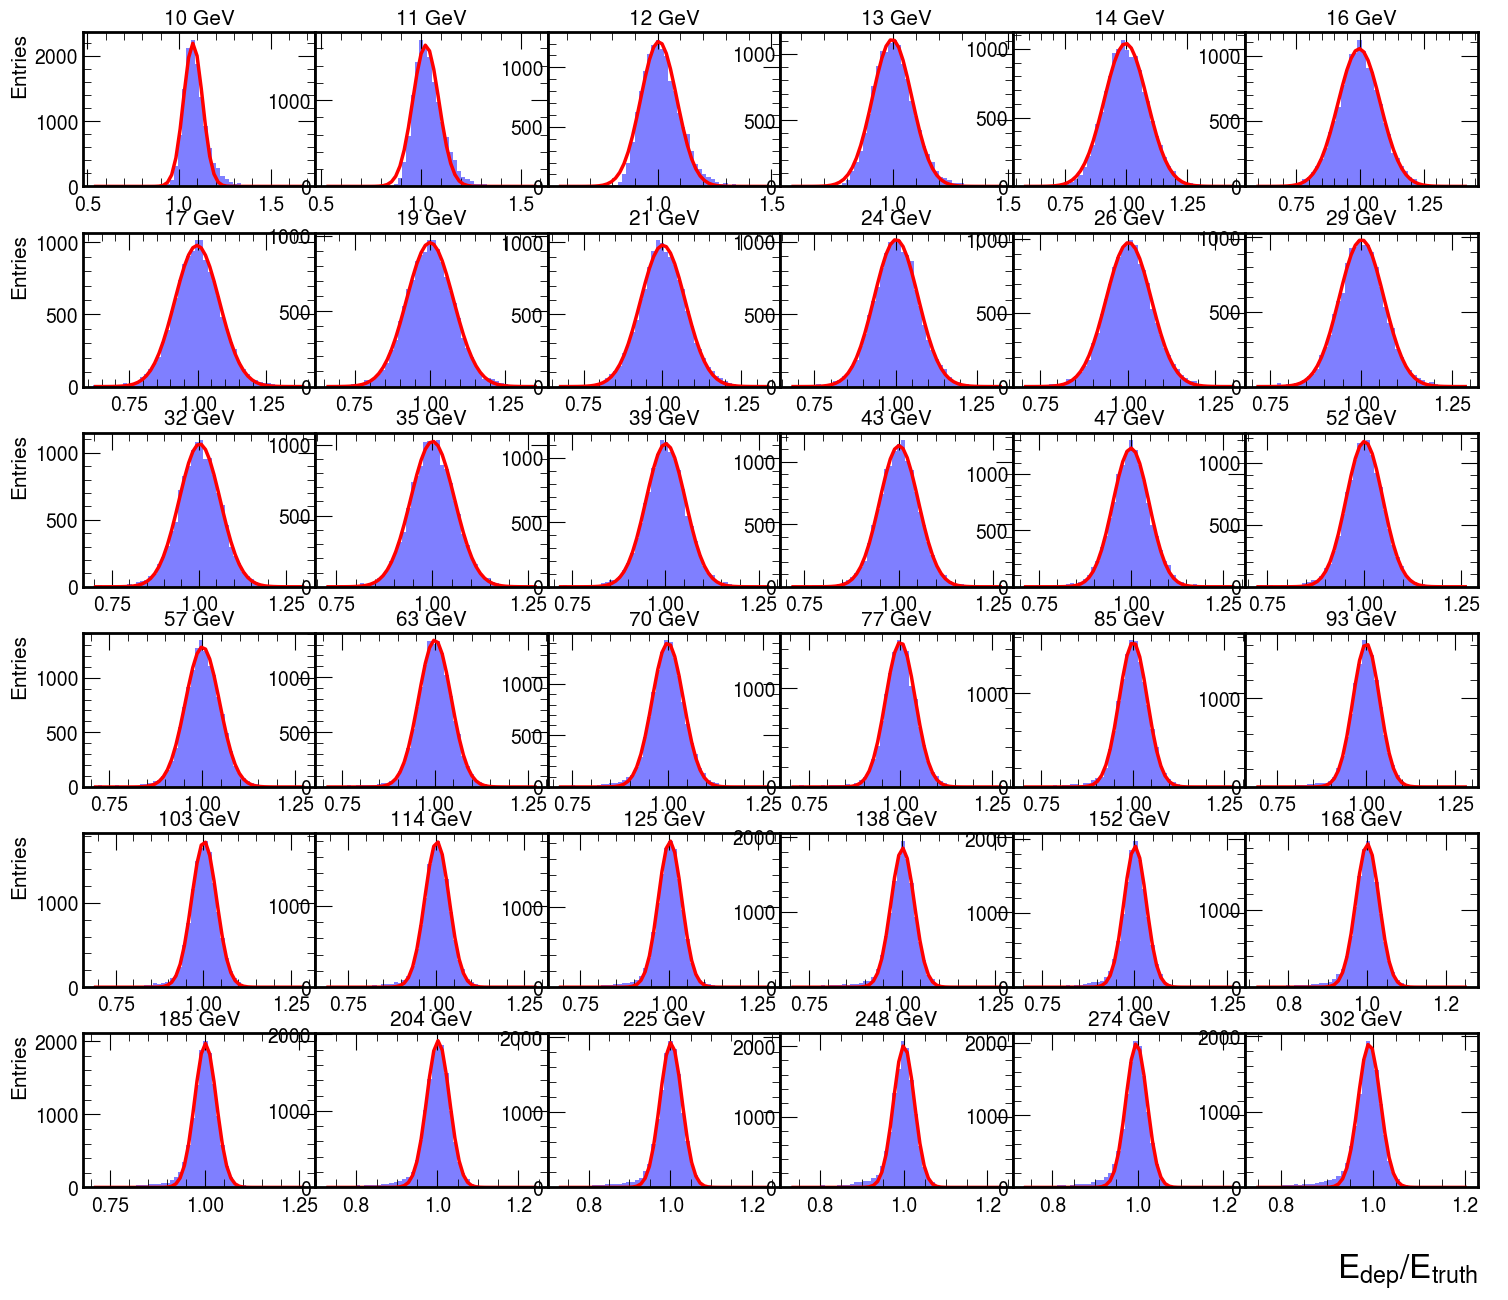

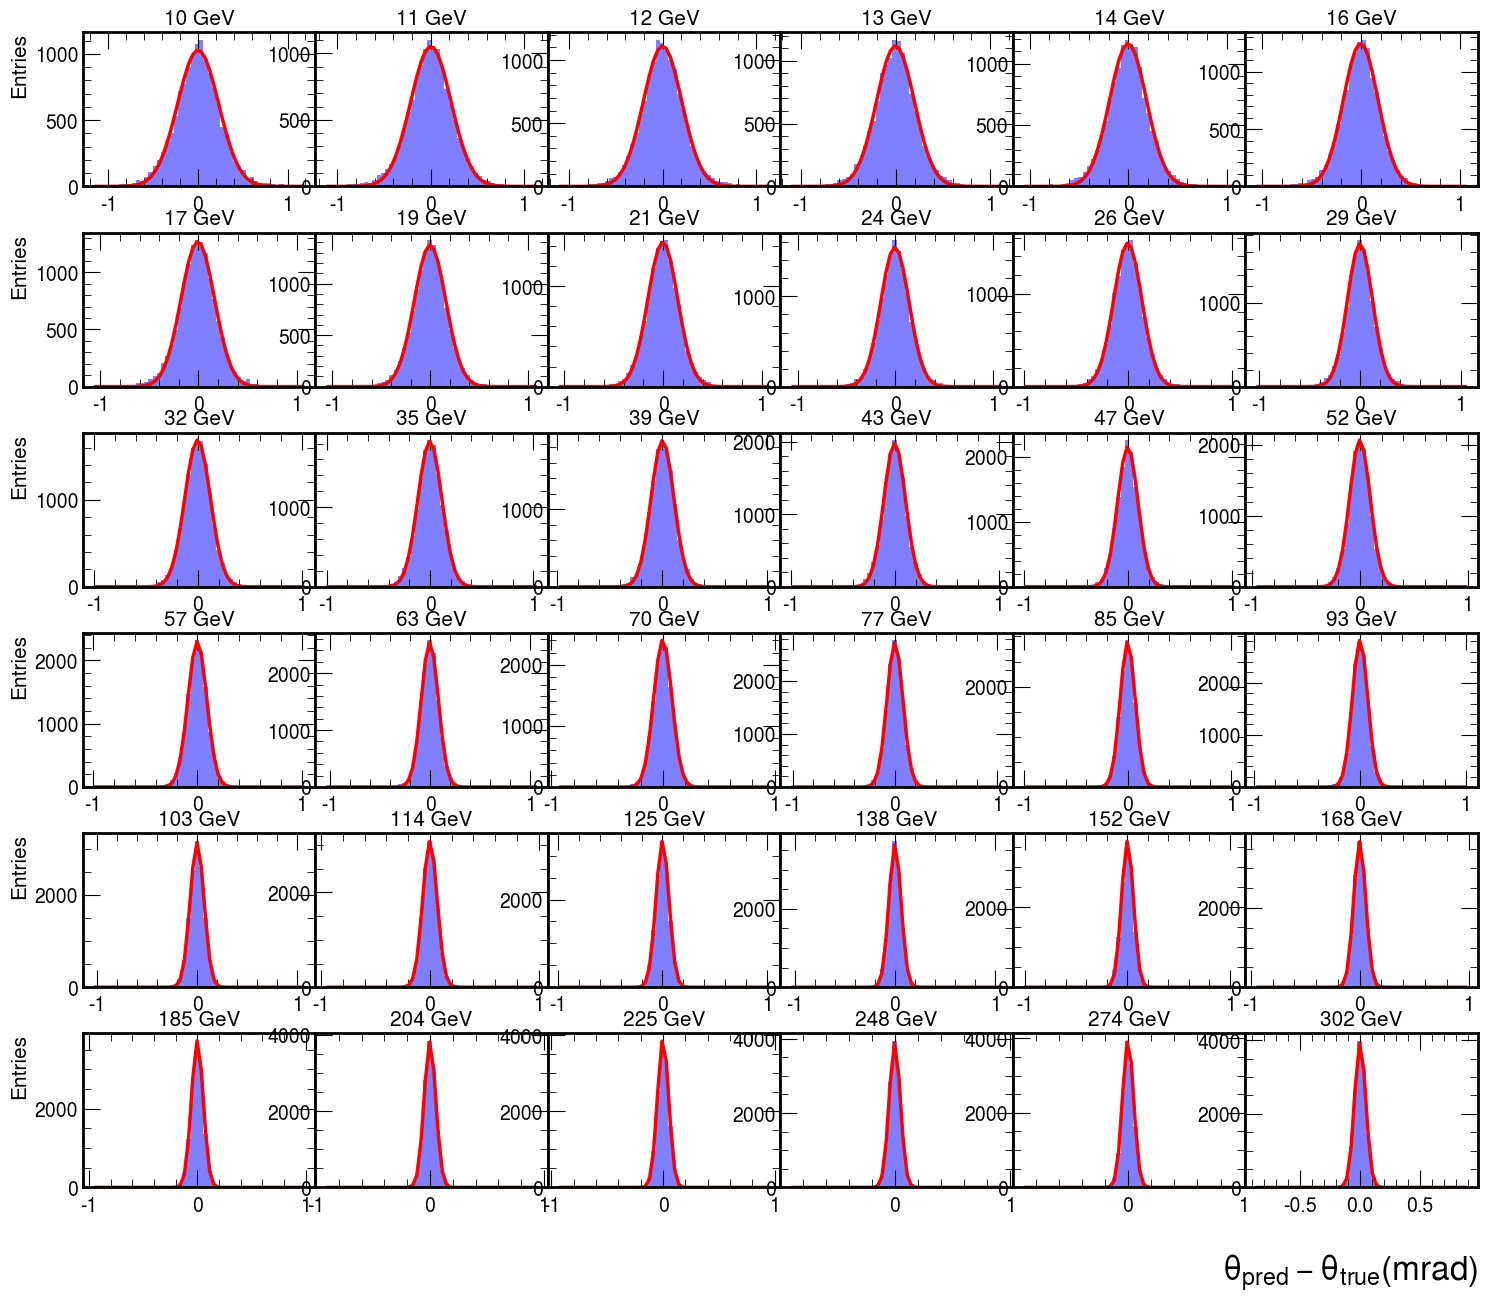

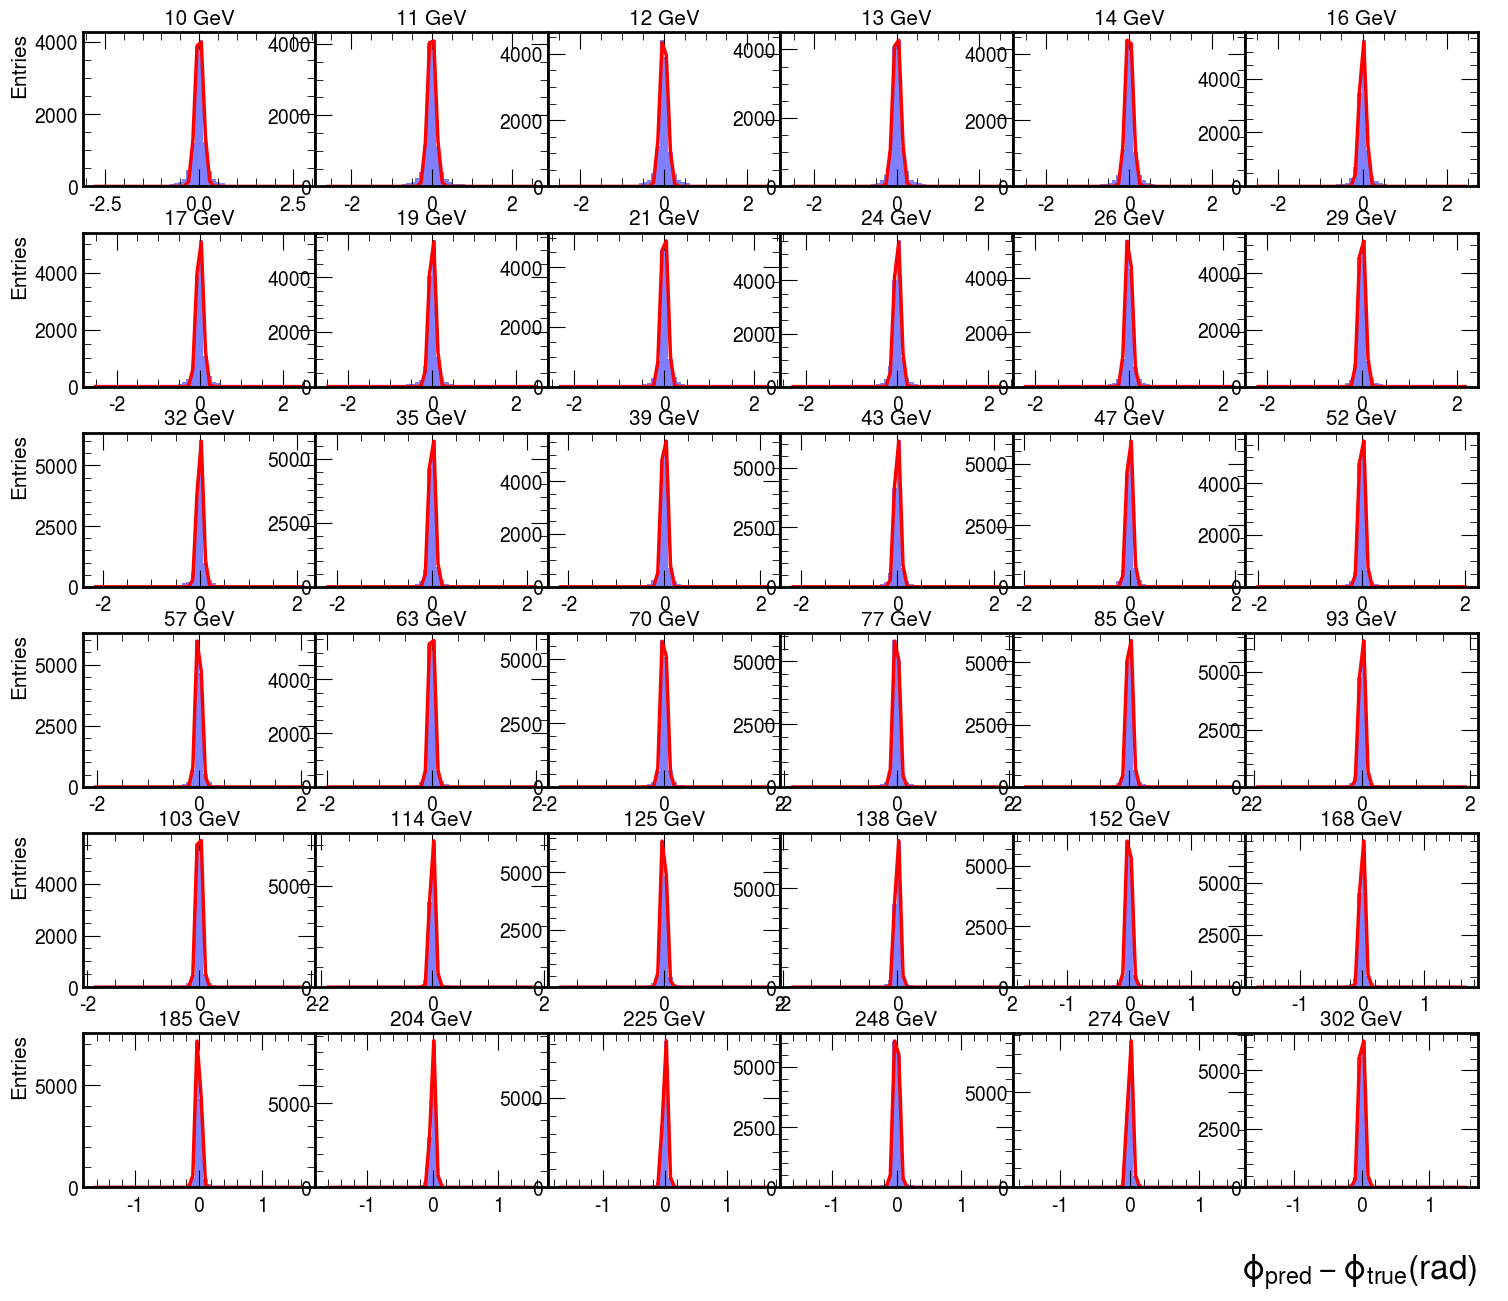

In [9]:
truth_energies, energy_resolutions, energy_scales, energy_leakage = get_resolutions(predictions_energy,
                                                                                    targets_energy,
                                                                                    energy_bins,
                                                                                    nbins = 50,
                                                                                    data_name = "energy",
                                                                                    divide_by_genE = True)
if output_dim =='2D' or output_dim =='3D':
    theta_predicted_truth_difference = predictions_theta - targets_theta
    _, theta_resolutions, _, _ = get_resolutions(theta_predicted_truth_difference,
                                                 targets_energy,
                                                 energy_bins,
                                                 nbins = 50,
                                                 data_name = "theta")
    
if output_dim =='3D':
    phi_predicted_truth_difference = predictions_phi - targets_phi
    _, phi_resolutions, _, _ = get_resolutions(phi_predicted_truth_difference,
                                               targets_energy,
                                               energy_bins,
                                               nbins = 50,
                                               data_name = "phi")

### Plotting energy results

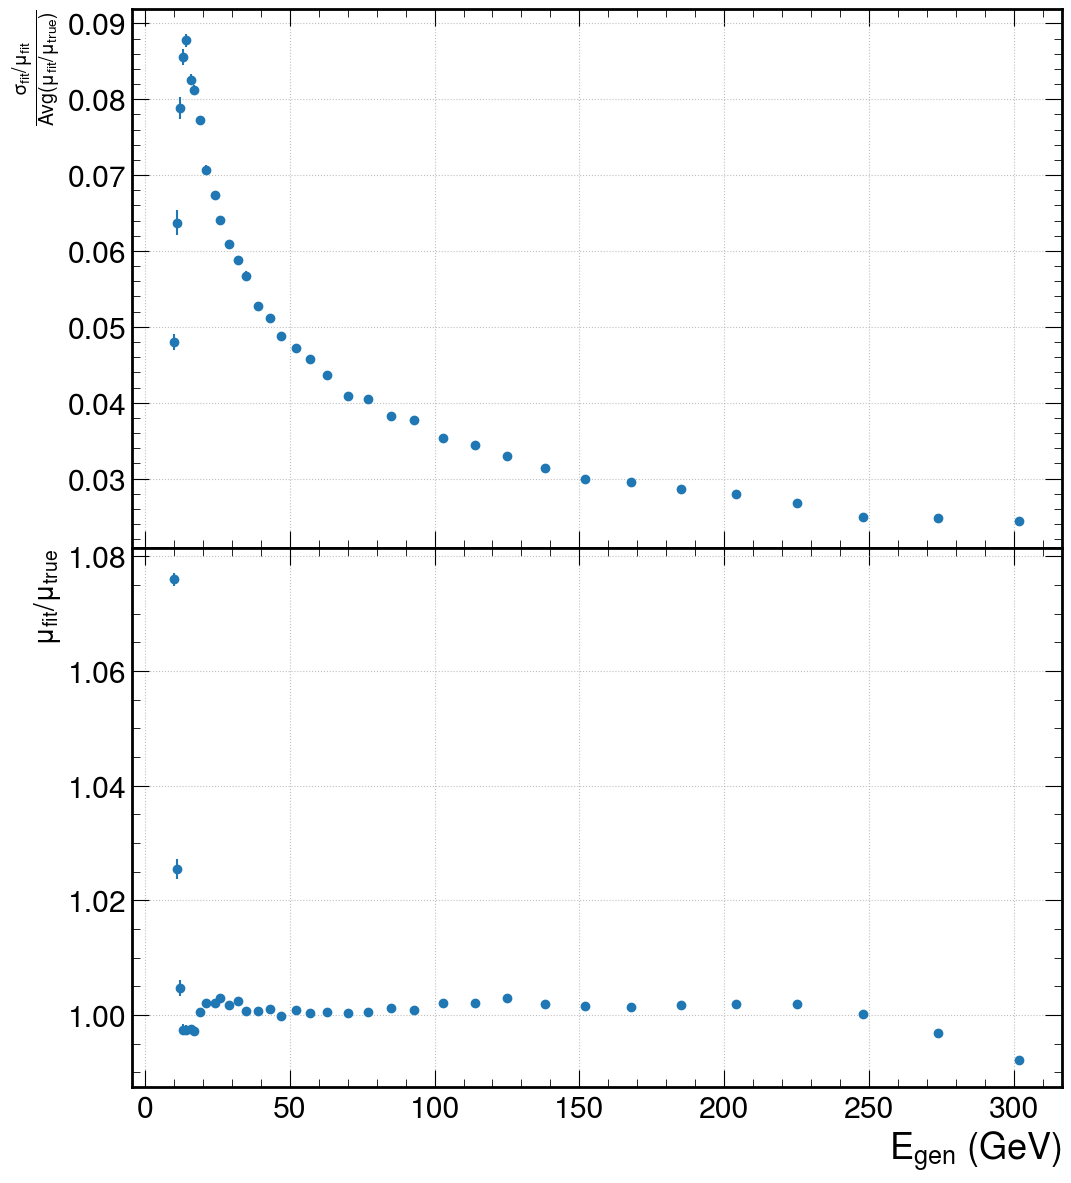

In [10]:
fig = plt.figure(figsize=(12,14))
fig.set_facecolor('w')
gs = fig.add_gridspec(2, hspace=0)
axs = gs.subplots(sharex=True, sharey=False)
axs[0].errorbar(truth_energies,
                energy_resolutions[0],
                yerr = energy_resolutions[1],
                marker='o',
                linestyle='none')
axs[0].set_ylabel("$\\frac{\sigma_{fit}/\mu_{fit}}{Avg (\mu_{fit}/\mu_{true})}$",  fontsize=20)

axs[1].errorbar(truth_energies,
                energy_scales[0],
                yerr = energy_scales[1],
                marker='o',
                linestyle='none')

axs[1].set_ylabel("$\mu_{fit}/\mu_{true}$",  fontsize=20)
axs[1].set_xlabel("$E_{gen}$ (GeV)")
axs[0].grid()
axs[1].grid()

### Plotting theta results

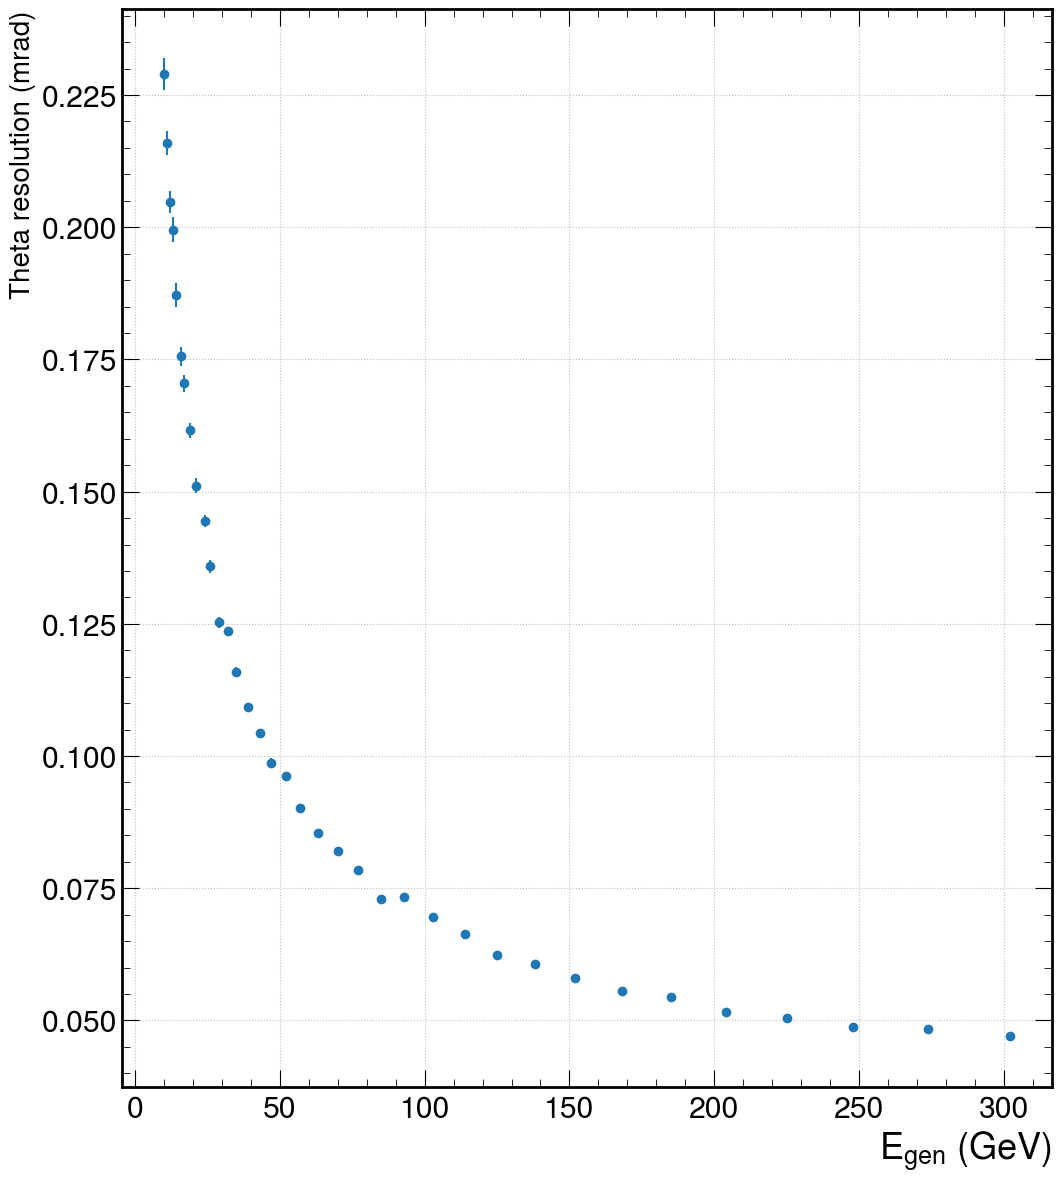

In [11]:
if output_dim =='2D' or output_dim == '3D':
    fig = plt.figure(figsize=(12,14))
    fig.set_facecolor('w')
    plt.errorbar(truth_energies,
                theta_resolutions[0],
                yerr = theta_resolutions[1],
                marker='o',
                linestyle='none')
    
    plt.ylabel("Theta resolution (mrad)",  fontsize=20)
    plt.xlabel("$E_{gen}$ (GeV)")
    plt.grid()

### Plotting phi results

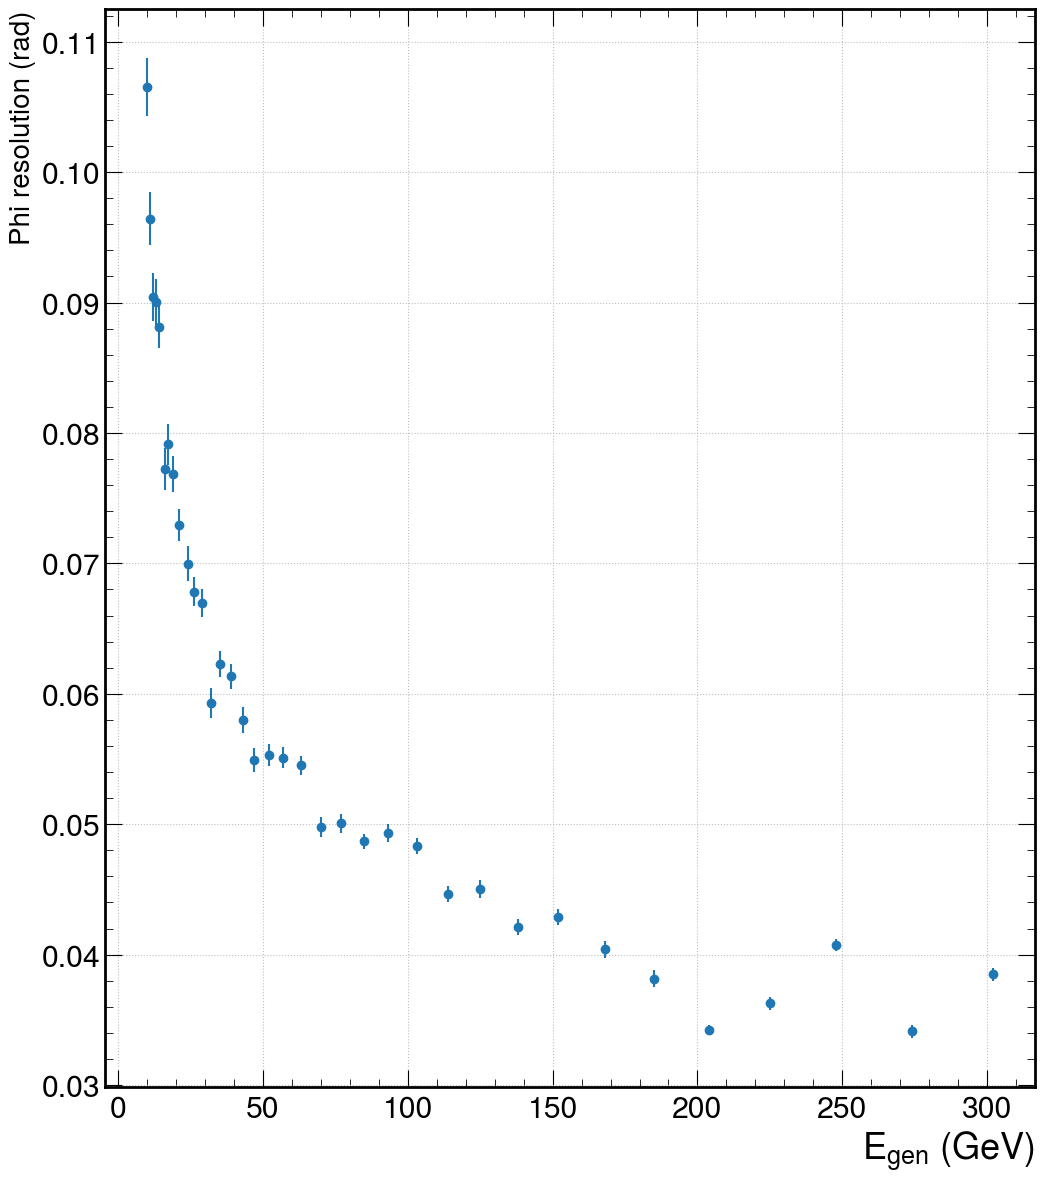

In [12]:
if output_dim =='3D':
    fig = plt.figure(figsize=(12,14))
    fig.set_facecolor('w')
    plt.errorbar(truth_energies,
                phi_resolutions[0],
                yerr = phi_resolutions[1],
                marker='o',
                linestyle='none')
    
    plt.ylabel("Phi resolution (rad)",  fontsize=20)
    plt.xlabel("$E_{gen}$ (GeV)")
    plt.grid()